
# Credit Card Approval Prediction

### Introduction
 Dataset has tow files which is downloded from Kaggle. First file containes client information like income, age, size of family, ... .
 Second file includes clients' credit status based on repayment history.
 In this project we are going to see the correlation between the features and predict which feature can predict clients' credit score.

### What Is a Credit Score?
A credit score is a number between 300–850 that depicts a consumer's creditworthiness. The higher the score, the better a borrower looks to potential lenders. A credit score is based on credit history: number of open accounts, total levels of debt, and repayment history, and other factors. Lenders use credit scores to evaluate the probability that an individual will repay loans in a timely manner.



### Importing Libraries and Dataset

In [1]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics as mt
from math import sqrt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from missingno import matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
kfold = KFold(5)
import scikitplot as skplt
from imblearn.over_sampling import SMOTE

In [2]:
#importing dataset
client_info = pd.read_csv('application_record.csv')
credit_record = pd.read_csv('credit_record.csv')

In [3]:
#checking overall look of dataset 
client_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [4]:
#checking overall look of dataset 
credit_record.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [5]:
#calculating some statistical data
client_info.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,4.385570e+05,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465
std,5.716370e+05,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207
min,5.008804e+06,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.609375e+06,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,6.047745e+06,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,6.456971e+06,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,7.999952e+06,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


### EDA and Data Cleaning

<AxesSubplot:>

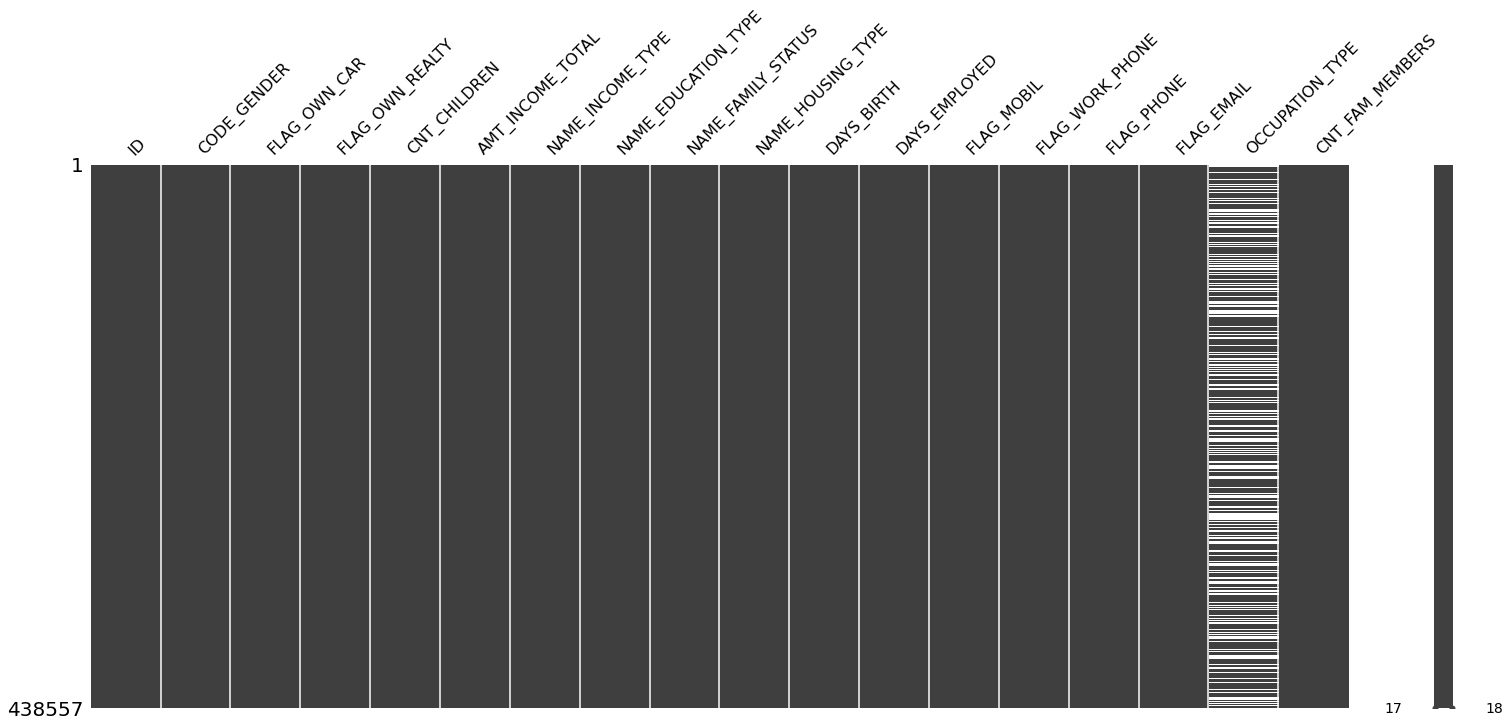

In [6]:
#checking null values among columns
matrix(client_info)

In [7]:
# dropping occupation type which has many null values
client_info.drop('OCCUPATION_TYPE', axis=1, inplace=True)

In [8]:
# Checking duplicates in 'ID' column and drop them all
len(client_info['ID']) - len(client_info['ID'].unique())

47

In [9]:
client_info = client_info.drop_duplicates('ID', keep='last') 

In [10]:
client_info['CNT_CHILDREN'].value_counts()

0     304038
1      88518
2      39879
3       5430
4        486
5        133
7          9
9          5
6          4
12         4
14         3
19         1
Name: CNT_CHILDREN, dtype: int64

#### Cleaning Client Info Dataset

In [11]:
#based on metadata positive number means client is currently unemployed. here, we check values greater
#then 0 and replace them with 0 so means client is unemployed currently
client_info[client_info['DAYS_EMPLOYED']>0]['DAYS_EMPLOYED'].unique()
client_info['DAYS_EMPLOYED'].replace(365243, 0, inplace=True)

In [12]:
#converting birth years and days employed into years and change column name
client_info['DAYS_BIRTH'] = np.abs (client_info['DAYS_BIRTH']/365)

In [13]:
#changing column name
client_info= client_info.rename(columns={'DAYS_BIRTH': 'AGE'})

In [14]:
#converting days employed to years
client_info['DAYS_EMPLOYED'] = abs(round(client_info['DAYS_EMPLOYED']/-365,0))

In [15]:
#changing column name
client_info= client_info.rename(columns={'DAYS_EMPLOYED': 'YEARS_EMPLOYED'})

In [16]:
#modify some columns to make the values more consistent 

client_info['NAME_HOUSING_TYPE'] = client_info['NAME_HOUSING_TYPE'].replace({'House / apartment' : 'House / apartment',
                                                                              'With parents': 'With parents',
                                                                              'Municipal apartment' : 'House / apartment',
                                                                              'Rented apartment': 'House / apartment',
                                                                              'Office apartment': 'House / apartment',
                                                                              'Co-op apartment': 'House / apartment',
                                                                            'House / apartmen':'House / apartment'})

client_info['NAME_INCOME_TYPE'] = client_info['NAME_INCOME_TYPE'].replace({'Commercial associate':'Working',
                                                                             'State servant':'Working',
                                                                             'Working':'Working',
                                                                             'Pensioner':'Pensioner',
                                                                             'Student':'Student'})

client_info['NAME_EDUCATION_TYPE'] = client_info['NAME_EDUCATION_TYPE'].replace({'Secondary / secondary special':'secondary',
                                                                                     'Lower secondary':'secondary',
                                                                                     'Higher education':'Higher education',
                                                                                     'Incomplete higher':'Higher education',
                                                                                     'Academic degree':'Academic degree'
                                                                                     })

client_info['NAME_FAMILY_STATUS'] = client_info['NAME_FAMILY_STATUS'].replace({'Single / not married':'Single',
                                                                                         'Separated':'Single',
                                                                                         'Widow':'Single',
                                                                                         'Civil marriage':'Married',
                                                                                         'Married':'Married'})
    
    

#### Binary Classification For Non-Numeric Values

In [17]:

client_info['CODE_GENDER'].replace(['F'],0, inplace=True)
client_info['CODE_GENDER'].replace(['M'],1, inplace=True)

In [18]:
client_info['FLAG_OWN_CAR'].replace(['Y'],1, inplace=True)
client_info['FLAG_OWN_CAR'].replace(['N'],0, inplace=True)

In [19]:
client_info['NAME_INCOME_TYPE'].replace(['Working'],1, inplace=True)
client_info['NAME_INCOME_TYPE'].replace(['Pensioner'],2, inplace=True)
client_info['NAME_INCOME_TYPE'].replace(['Student'],0, inplace=True)

In [20]:
client_info['FLAG_OWN_REALTY'].replace(['Y'],1, inplace=True)
client_info['FLAG_OWN_REALTY'].replace(['N'],0, inplace=True)

In [21]:
client_info['NAME_EDUCATION_TYPE'].replace(['secondary'],0, inplace=True)
client_info['NAME_EDUCATION_TYPE'].replace(['Higher education'],1, inplace=True)
client_info['NAME_EDUCATION_TYPE'].replace(['Academic degree'],2, inplace=True)

In [22]:
client_info['NAME_FAMILY_STATUS'].replace(['Married'],0, inplace=True)
client_info['NAME_FAMILY_STATUS'].replace(['Single'],1, inplace=True)


In [23]:
client_info['NAME_HOUSING_TYPE'].replace(['With parents'],0, inplace=True)
client_info['NAME_HOUSING_TYPE'].replace(['House / apartment'],1, inplace=True)
client_info['NAME_HOUSING_TYPE'].replace(['Rent'],2, inplace=True)

In [24]:
client_info.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,YEARS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
0,5008804,1,1,1,0,427500.0,1,1,0,1,32.890411,12.0,1,1,0,0,2.0
1,5008805,1,1,1,0,427500.0,1,1,0,1,32.890411,12.0,1,1,0,0,2.0
2,5008806,1,1,1,0,112500.0,1,0,0,1,58.832877,3.0,1,0,0,0,2.0
3,5008808,0,0,1,0,270000.0,1,0,1,1,52.356164,8.0,1,0,1,1,1.0
4,5008809,0,0,1,0,270000.0,1,0,1,1,52.356164,8.0,1,0,1,1,1.0



Using different charts to see how columns look like. This helps to maximize the insight into a data set and into the underlying structure of it.

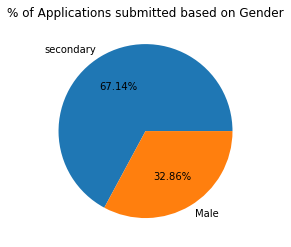

In [25]:
plt.pie(client_info['CODE_GENDER'].value_counts(), labels=['secondary', 'Male'], autopct='%1.2f%%')
plt.title('% of Applications submitted based on Gender')
plt.show()

Almost 70% of applicants are female

In [26]:
#removing some columns as they are not important in the analysis process
client_info.drop(columns=['FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL'], inplace=True)

In [27]:
#many applicants dont have children
client_info['CNT_CHILDREN'].value_counts()


0     304038
1      88518
2      39879
3       5430
4        486
5        133
7          9
9          5
6          4
12         4
14         3
19         1
Name: CNT_CHILDREN, dtype: int64

In [28]:
#number of families without children is high
client_info['CNT_FAM_MEMBERS'].value_counts()


2.0     233867
1.0      84483
3.0      77119
4.0      37351
5.0       5081
6.0        459
7.0        124
9.0          9
11.0         5
8.0          4
14.0         4
15.0         3
20.0         1
Name: CNT_FAM_MEMBERS, dtype: int64

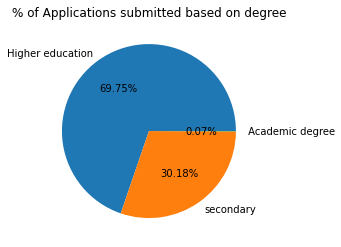

In [29]:

plt.pie(client_info['NAME_EDUCATION_TYPE'].value_counts(), labels=['Higher education', 'secondary', ' Academic degree'], autopct='%1.2f%%')
plt.title('% of Applications submitted based on degree')
plt.show()

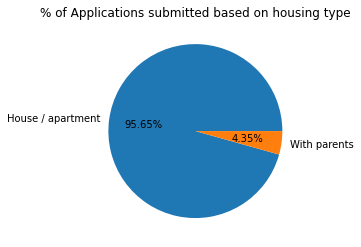

In [30]:
plt.pie(client_info['NAME_HOUSING_TYPE'].value_counts(), labels=['House / apartment', 'With parents'], autopct='%1.2f%%')
plt.title('% of Applications submitted based on housing type')
plt.show()

More than 95% of applicants have house/apartment

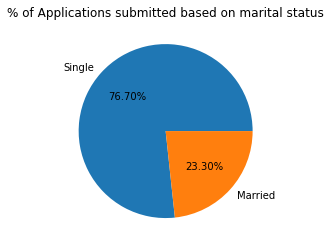

In [31]:
plt.pie(client_info['NAME_FAMILY_STATUS'].value_counts(), labels=['Single', 'Married'], autopct='%1.2f%%')
plt.title('% of Applications submitted based on marital status')
plt.show()

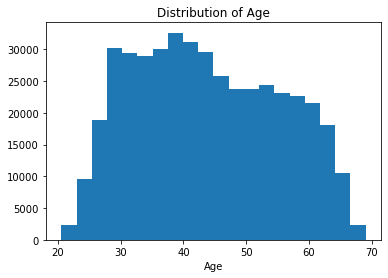

In [32]:
 #This graph shows that, majority of applicatant's are 25 to 65 years old
plt.hist(client_info['AGE'], bins=20)
plt.xlabel('Age')
plt.title('Distribution of Age')
plt.show()

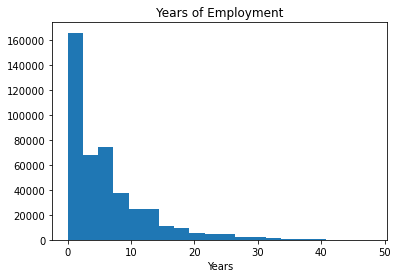

In [33]:
# This graph shows that, majority of applicatant's are Employed for 0 to 7 years
plt.hist(client_info['YEARS_EMPLOYED'], bins=20)
plt.xlabel('Years')
plt.title('Years of Employment')
plt.show()

In [34]:
client_info.corr()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,YEARS_EMPLOYED,CNT_FAM_MEMBERS
ID,1.000000,0.000509,0.000080,0.042728,-0.005174,0.011114,-0.002407,-0.003437,-0.004968,0.005992,0.004946,0.012019,-0.001873
CODE_GENDER,0.000509,1.000000,0.346574,-0.041959,0.086102,0.168811,-0.168408,0.001169,-0.094948,-0.053844,-0.193782,-0.016603,0.114174
FLAG_OWN_CAR,0.000080,0.346574,1.000000,-0.001296,0.115146,0.188223,-0.165743,0.095623,-0.136092,-0.011737,-0.163756,0.031407,0.156941
FLAG_OWN_REALTY,0.042728,-0.041959,-0.001296,1.000000,0.001564,0.025414,0.064332,-0.017980,-0.014512,0.139516,0.106889,-0.006542,0.008080
CNT_CHILDREN,-0.005174,0.086102,0.115146,0.001564,1.000000,0.019139,-0.242279,0.037989,-0.164933,-0.022794,-0.349080,0.039016,0.884780
AMT_INCOME_TOTAL,0.011114,0.168811,0.188223,0.025414,0.019139,1.000000,-0.140580,0.218298,0.008258,0.017800,-0.053781,0.075030,0.011415
NAME_INCOME_TYPE,-0.002407,-0.168408,-0.165743,0.064332,-0.242279,-0.140580,1.000000,-0.123829,0.083274,0.090360,0.621388,-0.411913,-0.234761
NAME_EDUCATION_TYPE,-0.003437,0.001169,0.095623,-0.017980,0.037989,0.218298,-0.123829,1.000000,0.015223,-0.038461,-0.173557,0.014342,0.023454
NAME_FAMILY_STATUS,-0.004968,-0.094948,-0.136092,-0.014512,-0.164933,0.008258,0.083274,0.015223,1.000000,-0.063392,0.052108,-0.059210,-0.603022
NAME_HOUSING_TYPE,0.005992,-0.053844,-0.011737,0.139516,-0.022794,0.017800,0.090360,-0.038461,-0.063392,1.000000,0.208320,0.040365,0.011417


#### Checking Outliers
It is important to forcast outliers to increse the power of statistical tests and ML prediction models.

<AxesSubplot:xlabel='ID', ylabel='NAME_HOUSING_TYPE'>

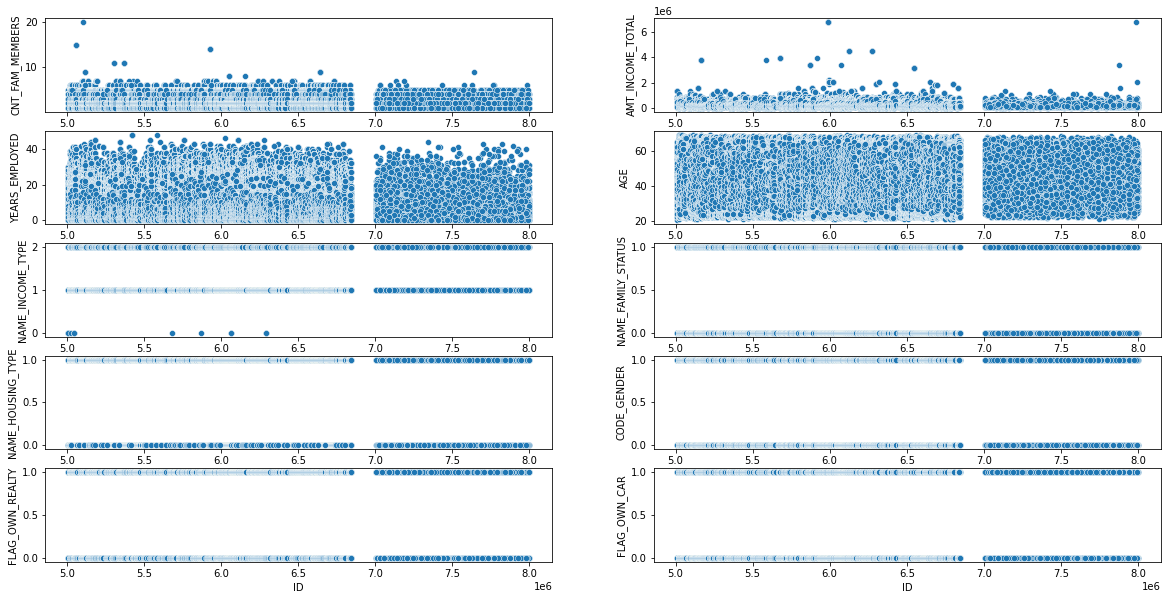

In [35]:
#overall look of columns using scatter plot. this helps to see outliers of each column
fig, ax= plt.subplots(nrows= 5, ncols = 2, figsize= (20,10))

sns.scatterplot(x='ID', y='AMT_INCOME_TOTAL', data=client_info, ax=ax[0][1])
sns.scatterplot(x='ID', y='CNT_FAM_MEMBERS', data=client_info, ax=ax[0][0])
sns.scatterplot(x='ID', y='YEARS_EMPLOYED', data=client_info, ax=ax[1][0])
sns.scatterplot(x='ID', y='AGE', data=client_info, ax=ax[1][1])


sns.scatterplot(x='ID', y='CODE_GENDER', data=client_info, ax=ax[3][1])
sns.scatterplot(x='ID', y='FLAG_OWN_REALTY', data=client_info, ax=ax[4][0])
sns.scatterplot(x='ID', y='FLAG_OWN_CAR', data=client_info, ax=ax[4][1])
sns.scatterplot(x='ID', y='NAME_INCOME_TYPE', data=client_info, ax=ax[2][0])
sns.scatterplot(x='ID', y='NAME_FAMILY_STATUS', data=client_info, ax=ax[2][1])
sns.scatterplot(x='ID', y='NAME_HOUSING_TYPE', data=client_info, ax=ax[3][0])


##### Note: There are outliers in some columns. We need to remove these outliers to make sure they do not affect our model results.


In [36]:
#remove the outlier for income 
highQ = client_info['AMT_INCOME_TOTAL'].quantile(0.999)
lowQ = client_info['AMT_INCOME_TOTAL'].quantile(0.001)
client_info= client_info[(client_info['AMT_INCOME_TOTAL']>lowQ) & (client_info['AMT_INCOME_TOTAL']<highQ)]

In [37]:
#remove the outlier for years employed 
highQ = client_info['CNT_FAM_MEMBERS'].quantile(0.999)
lowQ = client_info['CNT_FAM_MEMBERS'].quantile(0.001)
client_info= client_info[(client_info['CNT_FAM_MEMBERS']>lowQ) & (client_info['CNT_FAM_MEMBERS']<highQ)]

In [38]:
#remove the outlier for years employed 
#highQ = client_info['YEARS_EMPLOYED'].quantile(0.999)
#lowQ = client_info['YEARS_EMPLOYED'].quantile(0.001)
#client_info= client_info[(client_info['YEARS_EMPLOYED']>lowQ) & (client_info['YEARS_EMPLOYED']<highQ)]

In [39]:
#remove the outlier for age
#highQ = client_info['AGE'].quantile(0.999)
#lowQ = client_info['AGE'].quantile(0.001)
#client_info= client_info[(client_info['AGE']>lowQ) & (client_info['AGE']<highQ)]

<AxesSubplot:xlabel='ID', ylabel='NAME_HOUSING_TYPE'>

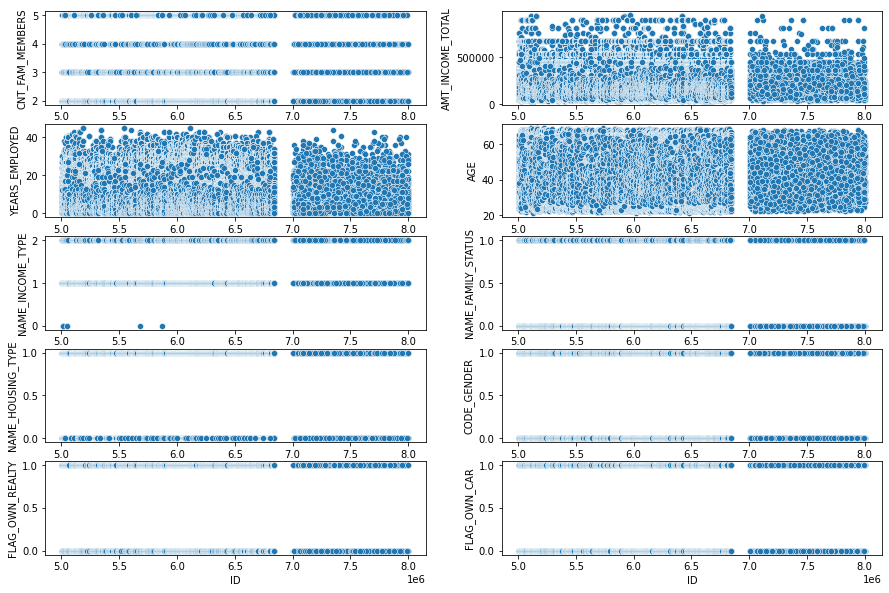

In [40]:
fig, ax= plt.subplots(nrows= 5, ncols = 2, figsize= (15,10))

sns.scatterplot(x='ID', y='AMT_INCOME_TOTAL', data=client_info, ax=ax[0][1])
sns.scatterplot(x='ID', y='CNT_FAM_MEMBERS', data=client_info, ax=ax[0][0])
sns.scatterplot(x='ID', y='YEARS_EMPLOYED', data=client_info, ax=ax[1][0])
sns.scatterplot(x='ID', y='AGE', data=client_info, ax=ax[1][1])


sns.scatterplot(x='ID', y='CODE_GENDER', data=client_info, ax=ax[3][1])
sns.scatterplot(x='ID', y='FLAG_OWN_REALTY', data=client_info, ax=ax[4][0])
sns.scatterplot(x='ID', y='FLAG_OWN_CAR', data=client_info, ax=ax[4][1])
sns.scatterplot(x='ID', y='NAME_INCOME_TYPE', data=client_info, ax=ax[2][0])
sns.scatterplot(x='ID', y='NAME_FAMILY_STATUS', data=client_info, ax=ax[2][1])
sns.scatterplot(x='ID', y='NAME_HOUSING_TYPE', data=client_info, ax=ax[3][0])

### Cleaning Credit Record Dataset

##### Based on metadata, there are diffrenet indexes which specify the status of credit:
 X: No loan for the month 

 0: 1-29 days past due

 C: paid off that month

 1: 30-59 days past due

 2: 60-89 days overdue

 3: 90-119 days overdue

 4: 120-149 days overdue

 5: Overdue or bad debts, write-offs for more than 150 days

#### Clients with passed due status are considered incredible, and clients with no loan or paid off status are regarded credible.  Here , credit record status is defined based on binary classification: 0 is credible and 1 is incredible client.

In [41]:
#checking the number of client for each category of credit status.0 means good clients and 1 means bad client
credit_record['STATUS'].value_counts()

C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: STATUS, dtype: int64

In [42]:
#C and X are the same type so define them as 0
#others classified as 1 as they are same type of status
credit_record['STATUS'].replace({'C': 0, 'X' : 0}, inplace=True)
credit_record['STATUS'] = credit_record['STATUS'].astype('int')
credit_record['STATUS'] = credit_record['STATUS'].apply(lambda x:1 if x >= 2 else 0)

In [43]:
#grouping the data by ID
credit_record = credit_record.groupby('ID').agg(max).reset_index()

In [44]:
#changing the type of status into integer
credit_record['STATUS'] = credit_record['STATUS'].astype('int')
print (credit_record.head())

        ID  MONTHS_BALANCE  STATUS
0  5001711               0       0
1  5001712               0       0
2  5001713               0       0
3  5001714               0       0
4  5001715               0       0


In [45]:
#Normalization makes the features more consistent with each other and allows the model to predict outputs more accurately
#credit_record['STATUS'].value_counts(normalize=True)*100

98% of credit record status is 0 which mean data is not balanced. This needs to be fixed in order to have an accurate analysis. 

In [46]:
#removing month balance column as it's not necessary for the analysis
credit_record.drop('MONTHS_BALANCE',axis=1, inplace=True)

In [47]:
#final look of credit record dataset
credit_record.head()

,ID,STATUS
0,5001711,0
1,5001712,0
2,5001713,0
3,5001714,0
4,5001715,0


### Final Dataframe
Making the final dataframe by joining 'client info' dataset with 'credit record' dataset and removing ID column

In [48]:

final_df = client_info.merge(credit_record,on = 'ID')

In [49]:
final_df.drop('ID', axis=1, inplace=True)

In [50]:
#the final dataframe is now ready to be used for analysis
final_df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,YEARS_EMPLOYED,CNT_FAM_MEMBERS,STATUS
0,1,1,1,0,427500.0,1,1,0,1,32.890411,12.0,2.0,0
1,1,1,1,0,427500.0,1,1,0,1,32.890411,12.0,2.0,0
2,1,1,1,0,112500.0,1,0,0,1,58.832877,3.0,2.0,0
3,1,1,1,0,270000.0,1,1,0,1,46.224658,2.0,2.0,0
4,1,1,1,0,270000.0,1,1,0,1,46.224658,2.0,2.0,0


In [51]:
final_df.shape

(29313, 13)

In [52]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29313 entries, 0 to 29312
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CODE_GENDER          29313 non-null  int64  
 1   FLAG_OWN_CAR         29313 non-null  int64  
 2   FLAG_OWN_REALTY      29313 non-null  int64  
 3   CNT_CHILDREN         29313 non-null  int64  
 4   AMT_INCOME_TOTAL     29313 non-null  float64
 5   NAME_INCOME_TYPE     29313 non-null  int64  
 6   NAME_EDUCATION_TYPE  29313 non-null  int64  
 7   NAME_FAMILY_STATUS   29313 non-null  int64  
 8   NAME_HOUSING_TYPE    29313 non-null  int64  
 9   AGE                  29313 non-null  float64
 10  YEARS_EMPLOYED       29313 non-null  float64
 11  CNT_FAM_MEMBERS      29313 non-null  float64
 12  STATUS               29313 non-null  int32  
dtypes: float64(4), int32(1), int64(8)
memory usage: 3.0 MB


In [53]:
#checking again if there is any duplicate value
len(final_df) - len(final_df.drop_duplicates())

21372

In [54]:
#removing duplicate values
final_df = final_df.drop_duplicates()

In [55]:
len(final_df) - len(final_df.drop_duplicates())

0

In [56]:
#checking for any null values
final_df.isnull().sum()

CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
AGE                    0
YEARS_EMPLOYED         0
CNT_FAM_MEMBERS        0
STATUS                 0
dtype: int64

In [57]:
# overall look of dataframe after cleaning
final_df.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7941 entries, 0 to 29312
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CODE_GENDER          7941 non-null   int64  
 1   FLAG_OWN_CAR         7941 non-null   int64  
 2   FLAG_OWN_REALTY      7941 non-null   int64  
 3   CNT_CHILDREN         7941 non-null   int64  
 4   AMT_INCOME_TOTAL     7941 non-null   float64
 5   NAME_INCOME_TYPE     7941 non-null   int64  
 6   NAME_EDUCATION_TYPE  7941 non-null   int64  
 7   NAME_FAMILY_STATUS   7941 non-null   int64  
 8   NAME_HOUSING_TYPE    7941 non-null   int64  
 9   AGE                  7941 non-null   float64
 10  YEARS_EMPLOYED       7941 non-null   float64
 11  CNT_FAM_MEMBERS      7941 non-null   float64
 12  STATUS               7941 non-null   int32  
dtypes: float64(4), int32(1), int64(8)
memory usage: 837.5 KB


## Find Correlation
Correlation refers to the statistical relationship between two entities. In other words, it's how two variables move in relation to one another

In [58]:
final_df.corr()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,YEARS_EMPLOYED,CNT_FAM_MEMBERS,STATUS
CODE_GENDER,1.000000,0.350508,-0.052841,0.048366,0.216388,-0.127647,-0.014283,-0.061527,-0.020084,-0.092698,-0.031264,0.067679,0.011662
FLAG_OWN_CAR,0.350508,1.000000,-0.010906,0.058352,0.216981,-0.121424,0.099939,-0.049983,-0.002761,-0.093582,0.009903,0.074078,-0.005895
FLAG_OWN_REALTY,-0.052841,-0.010906,1.000000,-0.006293,0.023421,0.078774,-0.010095,-0.014093,0.123896,0.125868,-0.023613,-0.003751,-0.034410
CNT_CHILDREN,0.048366,0.058352,-0.006293,1.000000,0.036244,-0.248124,0.045251,0.200193,-0.046147,-0.394136,0.025930,0.959524,0.009249
AMT_INCOME_TOTAL,0.216388,0.216981,0.023421,0.036244,1.000000,-0.152519,0.244774,0.014484,0.022688,-0.051570,0.079237,0.031842,0.007191
NAME_INCOME_TYPE,-0.127647,-0.121424,0.078774,-0.248124,-0.152519,1.000000,-0.114918,-0.081985,0.081558,0.596613,-0.397177,-0.228191,0.025114
NAME_EDUCATION_TYPE,-0.014283,0.099939,-0.010095,0.045251,0.244774,-0.114918,1.000000,0.013091,-0.056806,-0.167090,0.019201,0.041523,0.010798
NAME_FAMILY_STATUS,-0.061527,-0.049983,-0.014093,0.200193,0.014484,-0.081985,0.013091,1.000000,-0.026556,-0.095975,0.019608,-0.073634,0.068360
NAME_HOUSING_TYPE,-0.020084,-0.002761,0.123896,-0.046147,0.022688,0.081558,-0.056806,-0.026556,1.000000,0.184118,0.029520,-0.039907,0.006741
AGE,-0.092698,-0.093582,0.125868,-0.394136,-0.051570,0.596613,-0.167090,-0.095975,0.184118,1.000000,-0.012958,-0.372696,-0.000625


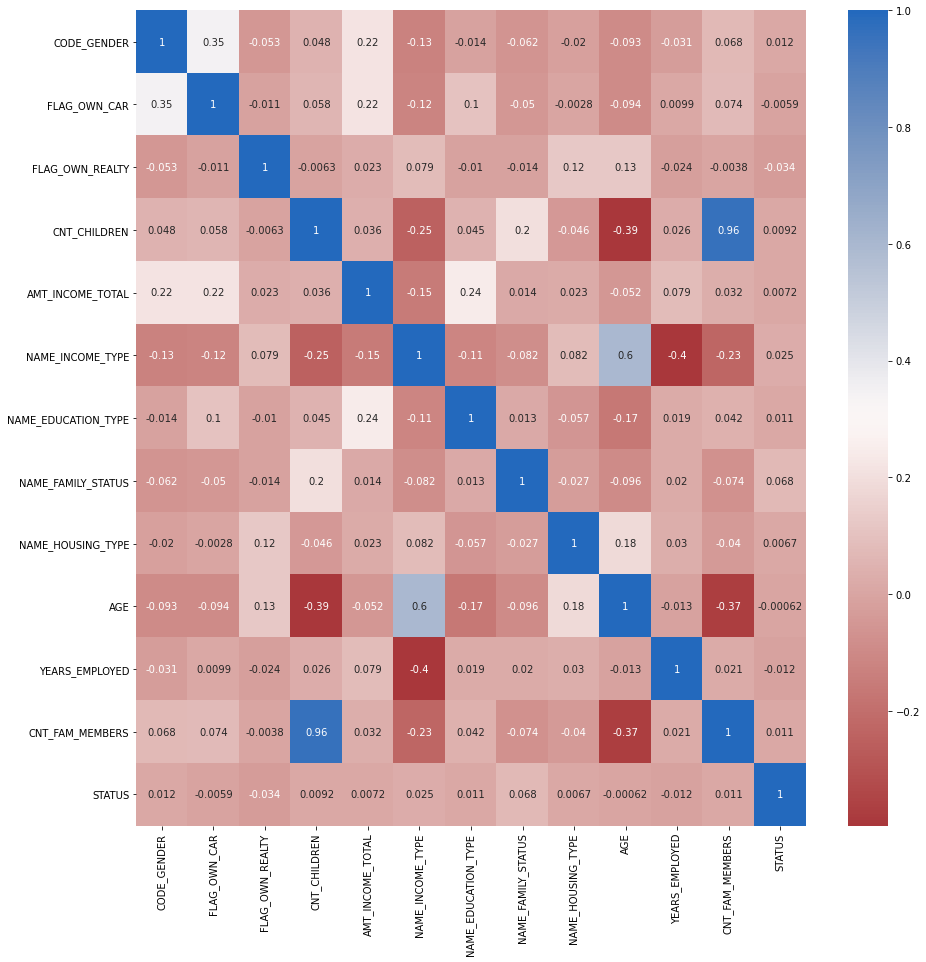

In [59]:
#visualizing the correlation to have a better understnding
plt.figure(figsize=(15,15))
cor = final_df.corr()
sns.heatmap(cor, annot=True, cmap="vlag_r")
plt.show()

The strongest correlation is considered when the value is closest to +1 (positive correlation) or -1 (negative correlation)
As we can see, 'CNT CHILDREN' and 'CNT FAM MEMBERS' are strongly correlated. we have to remove one because it might weakens the statistical power of your regression model.

In [60]:
final_df.drop(columns=['CNT_CHILDREN'], inplace=True)

In [61]:
# including all previous columns, only dropping the dependent variable 'progress'
X = final_df.drop(labels='STATUS', axis=1)


In [62]:
# ensuring our y (prediction) is only included
y = final_df['STATUS']

In [63]:
y

0        0
2        0
3        0
5        0
11       0
        ..
29308    1
29309    1
29310    1
29311    1
29312    1
Name: STATUS, Length: 7941, dtype: int32

## Machine Learning Model
 I am going to use tow models 1. Logistic Regression Model: It is used to understand the relationship between the dependent variable and one or more independent variables by estimating probabilities using a logistic regression equation. 
This type of analysis can help you predict the likelihood of an event happening or a choice being made. 2.Random Forest Model: This model is used to solve regression and classification problems. It utilizes ensemble learning, which is a technique that combines many classifiers to provide solutions to complex problems.

In [64]:
#break down dataset into Train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1337)

In [65]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5558, 11)
(2383, 11)
(5558,)
(2383,)


In [66]:
#initializing our logistic regression model,
#set the maximum iterations to 3000 so that the model can find a solution.

lr = LogisticRegression(random_state=7007, max_iter=3000)
lr.fit(X_train, y_train)

# using our model to predict
y_pred = lr.predict(X_test)

# evaluation
print("Accuracy Score:",accuracy_score(y_test, y_pred)*100, '%')

Accuracy Score: 95.5937893411666 %


Accuracy Score is one metric for evaluating classification models which determines how many of the predicted labels match exactly to our test set.The higher the scores the more accurate the predicts. Here, we have accuracy of 96% which is amazing. 

In [67]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2278
           1       0.00      0.00      0.00       105

    accuracy                           0.96      2383
   macro avg       0.48      0.50      0.49      2383
weighted avg       0.91      0.96      0.93      2383



C:\Users\Saba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Saba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Saba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Log regression accuracy was great, let's see if the Random Forest model can beat it.

In [68]:
# initializing our random forest model
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)

# using our model to predict
y_pred = rf.predict(X_test)

# accuracy score
print("Accuracy Score:",accuracy_score(y_test, y_pred)*100, '%')

Accuracy Score: 93.95719681074276 %


Accuracy score for random forest is not as high as previous model, let's see if Hyperparameter tuning can improve the score. Hyperparameter tuning can directly control the behaviour of the training algorithm and have a significant impact on the performance of the model is being trained.Hyperparameters refer to a configuration that is external to the model, which involves values the model cannot estimate from the data itself.

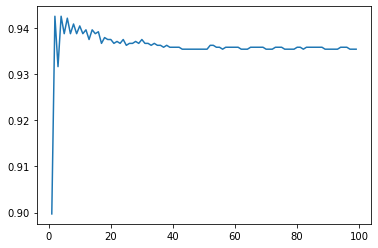

In [69]:
# the range of trees we want to test
numberoftrees = range(1, 100)
scores = []

# for loop
for n in numberoftrees:
    # in the n_estimators parameter, we're going to be testing all the values found in our range
    rf = RandomForestClassifier(n_estimators=n, random_state=1337)
    # fitting our model
    rf.fit(X_train, y_train)
    #prediction
    y_pred = rf.predict(X_test)
    # appending our result to variable scores
    scores.append(accuracy_score(y_test, y_pred))

# plotting our results
plt.plot(numberoftrees, scores)

The chart shows us that the optimal number is achieved around iteration 3 or so. If we rerun our model with 4 estimators with the same random seed selected above, we should see our accuracy score reach its peak value.

In [70]:
# initializing our random forest model
rf = RandomForestClassifier(n_estimators=4, random_state=1337)
rf.fit(X_train, y_train)

# using our model to predict
y_pred = rf.predict(X_test)

# accuracy score
print("Accuracy Score:",accuracy_score(y_test, y_pred)*100, '%')

Accuracy Score: 94.25094418799831 %


It looks the score increased by almost 0.12 which is not substantial.

In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2278
           1       0.06      0.02      0.03       105

    accuracy                           0.94      2383
   macro avg       0.51      0.50      0.50      2383
weighted avg       0.92      0.94      0.93      2383



### Cross Validation
It is primarily used to estimate the skill of a machine learning model on unseen data,to ensure that we can reuse our training set to validate that our model is working.

In [77]:
print(cross_val_score(rf, X_train, y_train, cv=5))
print(np.mean(cross_val_score(rf, X_train, y_train, cv=5)))

[0.94784173 0.94514388 0.93794964 0.94689469 0.94689469]
0.9449449261472911


### Feature Importance
There is a way to see what is giving the predictive power to classify data. This technique assign a score to input features based on how useful they are at predicting a target variable. This will showcase which features are deemed to be important when making predictions, versus those that are not. Also give us more clues about what features we should focus on and which we can remove.

<AxesSubplot:title={'center':'Feature Importance'}>

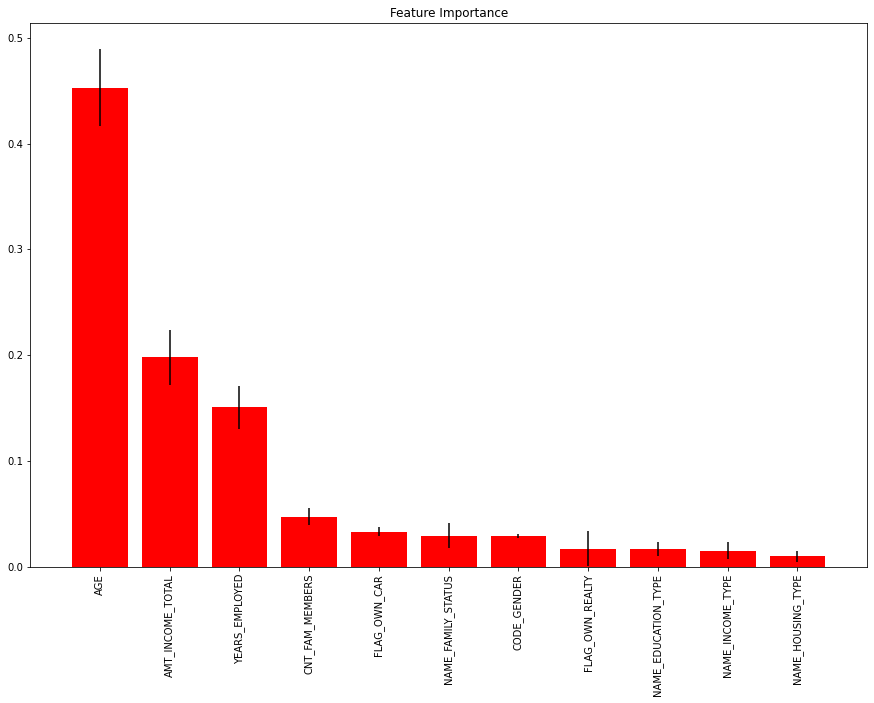

In [73]:

feature_names = X.columns

skplt.estimators.plot_feature_importances(rf, feature_names=feature_names, figsize=(15, 10), x_tick_rotation=90)

## Conclusion 
By analyzing our feature importance we're able to identify that the feature 'Age' is the strongest predictor of our model,
while the weakest is 'Name Houseing Type'. Understanding this can help us understand who is the best candidate to get a new credit card.